#### Imports

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import Window
from pyspark.sql.functions import *
from collections import Counter
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover, StringIndexer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import string
import re

#### SparkContext

In [ ]:
scala_version = '2.12'
spark_version = '3.2.1'
packages = [
    f'org.apache.spark:spark-sql-kafka-0-10_{scala_version}:{spark_version}',
    f'org.apache.spark:spark-streaming-kafka-0-10_{scala_version}:{spark_version}',
    f'org.apache.spark:spark-token-provider-kafka-0-10_{scala_version}:{spark_version}',
    'org.apache.kafka:kafka-clients:2.1.1',
    'org.apache.commons:commons-pool2:2.8.0'
]

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Real-time Sentiment Analysis with Kafka") \
    .config("spark.jars.packages", ",".join(packages)) \
    .getOrCreate()

spark.sparkContext.setLogLevel('ERROR')


#### SparkStreaming

In [3]:
broker = "EC2 DNS"
topic = "TOPIC_NAME"

dfraw = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", broker) \
    .option("subscribe", topic) \
    .option("includeHeaders", "true") \
    .option("startingOffsets","earliest") \
    .load()

In [4]:
df = dfraw.writeStream.queryName("sentiment_data").format("memory").start()

#### SparkSQL

In [5]:
df = spark.sql("select CAST(value AS STRING), topic, timestamp from sentiment_data")

In [7]:
df.count()

207

#### Data Extraction

In [8]:
schema = "array<struct<user_id:int, user_sex:string, user_age:int, user_country:string, rating:float, comment:string, favourite_character:string, date:string>>"
df = df.withColumn("parsed_value", from_json(col("value"), schema))
df = df.selectExpr( "explode(parsed_value) as parsed_value")
df = df.select(col("parsed_value.user_id").alias("user_id"), col("parsed_value.user_sex").alias("user_sex"), col("parsed_value.user_age").alias("user_age"), col("parsed_value.user_country").alias("user_country"), col("parsed_value.rating").alias("rating"), col("parsed_value.comment").alias("comment"), col("parsed_value.favourite_character").alias("favourite_character"), col("parsed_value.date").alias("date"))

#### Visualization

In [9]:
data = df.withColumn("sentiment", when(df["rating"] > 3.0, 'positive').when(df["rating"] < 3.0, 'negative').otherwise('neutral'))
data = data.withColumn("comments", regexp_replace("comment", "[^\w\s]", ""))

token = Tokenizer(inputCol='comments', outputCol='tokenized_comment')
data = token.transform(data)

stopwords = StopWordsRemover(inputCol='tokenized_comment', outputCol='cleaned_words')
data = stopwords.transform(data)

custom_stopwords = ["arc", "place", "make", "films"]
stopwords = StopWordsRemover(inputCol='cleaned_words', outputCol='cleaned_word', stopWords=custom_stopwords)
data = stopwords.transform(data)

data = data.withColumn("word", explode("cleaned_word"))

positive = data.filter(data['sentiment'] == 'positive')
positive = positive.groupBy("word",'sentiment').count().limit(5).orderBy('count', ascending=False).toPandas()

negative = data.filter(data['sentiment'] == 'negative')
negative = negative.groupBy("word", 'sentiment').count().limit(5).orderBy('count', ascending=False).toPandas()

neutral = data.filter(data['sentiment'] == 'neutral')
neutral = neutral.groupBy("word",'sentiment').count().limit(5).orderBy('count',ascending=False).toPandas()

In [ ]:
top_words = pd.concat([positive, negative, neutral])
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="word", hue="sentiment", data=top_words, palette={"positive": "green", "negative": "red", "neutral": "blue"})
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 5 Word Frequency by Sentiment')
plt.savefig('words.png')

#### Train Model 

In [11]:
# Drop full row duplicates
df = df.drop_duplicates()

# Create label based on rating
df = df.withColumn("label", when(df["rating"] > 3.0, 2.0).when(df["rating"] < 3.0, 0.0).otherwise(1.0))

# Balance each label  
window = Window.partitionBy("label").orderBy(rand())
df = df.withColumn("row_number", row_number().over(window))
df = df.filter("row_number <= 30").drop("row_number")

# Tokenize and remove stopwords
tokenizer = Tokenizer(inputCol="comment", outputCol="tokenized_comment")
stopwordsRemover = StopWordsRemover(inputCol='tokenized_comment', outputCol="meaningfulWords")

# Hash tokens into feature vectors
hashingTF = HashingTF(inputCol="meaningfulWords", outputCol="features")

# Create logistic regression model
lr = LogisticRegression(labelCol="label", featuresCol="features")

# Create pipeline
pipeline = Pipeline(stages=[tokenizer, stopwordsRemover, hashingTF, lr])

# Split data into train & test set
df_Train, df_Test = df.randomSplit([0.6, 0.4], seed=1)
model = pipeline.fit(df_Train)

# Save the trained model to disk
path = 'you_model_path'
model.write().overwrite().save(path)

# Load the trained model
loaded_model = PipelineModel.load(path)

#### Testing & Evaluating Sentiments

In [14]:
# Make predictions on test data
df_Test_predictions = loaded_model.transform(df_Test)

# Evaluate model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(df_Test_predictions)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.75


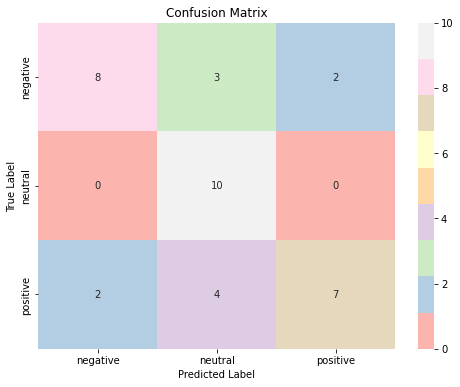

In [22]:
# Define a mapping dictionary for numeric labels to sentiment names
label_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}

# Extract true labels and predicted labels
true_labels = df_Test_predictions.select("label").rdd.map(lambda row: row[0]).collect()
predicted_labels = df_Test_predictions.select("prediction").rdd.map(lambda row: row[0]).collect()

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Pastel1", xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('cm')
plt.show()


# Predictions on the fly

### Fetch & Process Latest Data

In [19]:
# Load latest data from Kafka for real-time prediction
new_stream = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", broker) \
    .option("subscribe", topic) \
    .option("includeHeaders", "true") \
    .option("startingOffsets","latest") \
    .load()

new_stream = new_stream.writeStream.queryName("new_stream").format("memory").start()
new_stream = spark.sql("select CAST(value AS STRING), topic, timestamp from new_stream")

# Preprocess the streaming data
new_stream_processed = new_stream.withColumn("parsed_value", from_json(col("value"), schema)) \
    .selectExpr("explode(parsed_value) as parsed_value") \
    .select( col("parsed_value.user_id").alias("user_id"),
             col("parsed_value.comment").alias("comment"))

### Make real-time predictions

In [21]:
predictions = loaded_model.transform(new_stream_processed)
predictions.select('user_id', 'probability', 'prediction').show(5,False)

+-------+----------------------------------------------------------------+----------+
|user_id|probability                                                     |prediction|
+-------+----------------------------------------------------------------+----------+
|32     |[7.412399821091066E-10,1.1448663678510571E-9,0.9999999981138936]|2.0       |
|346    |[0.8178324521737941,8.333714675380888E-4,0.1813341763586679]    |0.0       |
|484    |[2.7168997194719404E-4,0.019169660259618766,0.9805586497684341] |2.0       |
|164    |[0.7381313030582177,0.04580833594345796,0.21606036099832426]    |0.0       |
|19     |[0.9997294769153968,1.9540708549074728E-5,2.5098237605408215E-4]|0.0       |
+-------+----------------------------------------------------------------+----------+
only showing top 5 rows

